# Monte Carlo-simuleringer av polymerfolding

### Introduksjon
Vi har i dette prosjektet sett på polymerer, et polymer er satt sammen av flere repeterende enheter, monomerer. Vi har laget et program der vi kan analysere polymerer med ulike lengder og tilfeldig simulerte rotasjoner. Ved rotasjon av polymerene får polymerene nye egenskaper. Bindingene mellom monomerene er så sterke at de ikke kan brytes, og det kan heller ikke dannes nye bindinger mellom monomerer som ikke allerede er nærmeste naboer. Det kan derimot oppstå vekselvirkninger mellom monomerer som ikke er nærmeste naboer. 


Vi har laget et program hvor man kan se på polymerer som er satt sammen av N antall monomerer. Ved å rotere polymerene rundt monomerer får polymerene nye egenskaper. Vekselvirkninger mellom monomerer kan oppstå under visse omstendigheter. Ved å bruke Monte Carlo-Simulering kan vi genere tilfeldig roterte polynomer med ulike egenskaper og energi. 


Koden i dette prosjektet inneholder mange større beregninger, noe som betyr at kjøretiden kan bli lang. Vi har derfor importert jit og njit fra numba for å kompliere koden og dermed minimere kjøretiden. I tillegg har vi også kun brukt numpy arrays, i stedet for vanlige python lister, da beregninger med numpy er mye raskere. 

In [78]:
%config InlineBackend.figure_formats = ['svg'] # Makes the plots svg (visually better) 

In [95]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from numba import njit, jit, int32 # Njit: No-Python mode, JIT (Just-In-Time compilation)
from tqdm.auto import tqdm, trange # Imported to use progress bars while running code
import timeit

Spørsmål til m:
- Burde plottet av den første polymeren være på positiv eller negativ y-akse? (-polymer[:,0])

#### Representasjon av polymerene
Vi har valgt å representere hvert polymer som et N x 2 array. Polymeren er satt sammen av flere monomerer, der hvert element i polymer-arrayet er en monomer. Vi vil sentrere polymeren på mitten av korrdinatsystemet for at det skal ha et bedre utgangspunkt når det skal roteres. (Seinere bruker vi kooordinaten til elementet i polymer-arrayet til å representere polymeren og monomerene i et kartesisk koordinatsystem???). 

Det er også mulig å representere et polymer av lengden N i et array av dimensjon M x M, der M => N. De resterende plassene i M x M arrayet, som ikke illustrer en monomer, ville vært representert av nullere. Dette ville vært overflødig data som vi ikke trenger for å arbeide videre med polymeren. Ved å lagre masse nullere, som vi ikke er avhegning av for å løse oppgavene, vil koden bli betydelig treigere.

Dermed har vi valgt å jobbe med et N x 2 array for å unngå overflødig lagring av data, og oppnå raskest mulig kjøretid. 


(Finne ut hvor mye raskere/hvor mye midre tid dette tar).

In [80]:
N = 7  # Lenght of polymer
M = 9  # Gitterdimension

@njit
def init_polymer(N):
    polymer = np.zeros((N, 2), dtype=np.int32) # Define the polymer as a Nx2 array with datatype 32 bit
    polymer[:, 1] = np.arange(N)
    polymer[:, 0] = M // 2
    return polymer

init_polymer(N)

array([[4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [4, 4],
       [4, 5],
       [4, 6]], dtype=int32)

#### Endemonomerer
Når vi skal velge hvilket monomer som polymeret skal roteres rundt, så velges dette tilfeldig. Noe som er verdt å merke seg da er at dersom et polymer skal roteres om et endepunkt, så vil det ikke endre noe og polymeren vil forbli i ro. Dette er fordi vi med fordel har valgt at det alltid er den korte enden som skal roteres. Siden energien bestemmes av formen til polymeren, og den forblir uendret ved rotasjon om endemonomer, så vil energien også forbli uendret. Det vil altså hverken oppstå eller forsvinne noen vekselvirkninger mellom monomerer. Dette medfører at det vil være hensiksmessig å ikke inkludere endemonomerene i det tilfeldige utvalget monomeren trekkes fra. Vi vil derfor kun trekke fra 1 til N-1 i arrayet når vi skal velge hvilket monomer som skal roteres rundt. Dette vil være for å minimere kjøretiden til koden, siden den slipper å kjøre gjennom unødvendige steg. 

#### Illustrasjon av polymerene
For å illustrere polymerene, plotter vi monomerene som prikker bundet sammen av linjer som illustrer hele polymeren. Hvert monomer har sin egen farge og tall, dette gjør det enkelt å skille monomerene fra bakgrunnen, og se hvilke rekkefølge de har i polymeren. Polymeren vi starter med er illustrert som en rett linje, denne er sentrert i midten av koordinatsystemet så det blir enklere å arbeide med seinere når det skal roteres. 

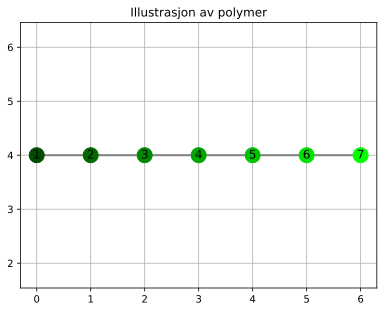

In [81]:
def plot_polymer(polymer):
    
    # Assuming 'polymer' is an Nx2 numpy array
    plt.figure()
    num_points = polymer.shape[0]

    # Generating different shades of green
    greens = np.linspace(0.3, 1, num_points)  # Adjust the range for different shades
    colors = [(0, green, 0, 1) for green in greens]  # RGB tuples with varying green component

    # Plotting the lines first
    plt.plot(polymer[:, 1], polymer[:, 0], 'o-', color='grey', markersize=10, linewidth=2)

    # Plotting each point and its number
    for i in range(num_points):
        
        # Plot each point with a different color
        plt.plot(polymer[i, 1], polymer[i, 0], 'o', color=colors[i], markersize=15)

        # Centering the number on the dot
        plt.text(polymer[i, 1], polymer[i, 0], str(i+1), color='black', fontsize=12, 
                 horizontalalignment='center', verticalalignment='center')

    plt.title("Illustrasjon av polymer")
    plt.axis('equal')
    plt.grid()
    plt.show()
    
plot_polymer(init_polymer(7))


#### Kreterium for polymerer
Vi har tatt utganspunkt i at bindingene mellom monomerene i polymerene ikke skal kunne brytes, det skal heller ikke være mulig at to monomerer ender opp på samme plass. For at dette alltid skal stemme må vi kjøre polymerene gjennom en funskjon som sjekker om polymeret vi jobber med ikke er et ødelagt polymer. Dette blir viktig seinere i programmet da polymerene skal roteres flere ganger, og slutt polymeret skal være et gyldig et polymer.

Vi har tatt utgangspunkt i at polymerene er N x 2-arrays og at monomerene har hver sin koordinat i arrayet. For at polymeren skal være gyldig er det tre viktige kriterier. 

Det første kriteriumet vi må ta hensyn til er at polymeren består av N monomerer. Dette sjekker vi ved å returne False dersom polymer-arrayet ikke har like mange elementer som lengden av arrayet. 

Det andre kriteriumet er at hvert monomer representers av et unikt heltall, altså at vi ikke har noen overlappende punkter. Dette sjekker vi ved å sjekke om det er noen identiske elementer i arrayet.

Det tredje kriteriumet er at monomer nummer m skal være nærmeste nabo med monomer nummer m-1 og m+1. Dette sjekker vi ved å se om avstanden mellom disse er 1. 

In [82]:
# e)

def polymer_check_slow(polymer: np.ndarray, N: int) -> bool:
    # Checks if polymer has correct length
    if len(polymer) != N:
        return False
    
    # Checks if polymer has overlapping points
    for i in range(N):
        for j in range(N):
            if i != j:
                if polymer[i][0] == polymer[j][0] and polymer[i][1] == polymer[j][1]:
                    return False
    
    # Checks if monomer m is nearest neighbour with m-1 and m+1
    for i in range(N):
        if i == 0 or i == N-1:
            if not ((np.abs(polymer[i,0]-polymer[i+(-1 if i else 1),0]) == 1 and np.abs(polymer[i,1]-polymer[i+(-1 if i else 1),1]) == 0) or 
                    (np.abs(polymer[i,1]-polymer[i+(-1 if i else 1),1]) == 1 and np.abs(polymer[i,0]-polymer[i+(-1 if i else 1),0]) == 0)):
                return False
        else:
            if not ((np.abs(polymer[i,0]-polymer[i+1,0]) == 1 and np.abs(polymer[i,1]-polymer[i+1,1]) == 0) or
                    (np.abs(polymer[i,1]-polymer[i+1,1]) == 1 and np.abs(polymer[i,0]-polymer[i+1,0]) == 0) or
                    (np.abs(polymer[i,0]-polymer[i-1,0]) == 1 and np.abs(polymer[i,1]-polymer[i-1,1]) == 0) or
                    (np.abs(polymer[i,1]-polymer[i-1,1]) == 1 and np.abs(polymer[i,0]-polymer[i-1,0]) == 0)):
                return False
    return True

# Argumenter for at naboene vil alltid vere like. Ved induksjon vil dette holde for alle roteringer så lenge man starter med en gyldig polymer.

@njit
def polymer_check(polymer: np.ndarray, N: int) -> bool:
    # Checks if polymer has correct length
    if len(polymer) != N:
        return False
    # Checks if polymer has overlapping points
    for i in range(N):
        for j in range(i + 1, N):
            if np.all(polymer[i] == polymer[j]):
                return False
            
    return True


#### Kodehastighet
I kodeblokken over har vi laget to ulike funksjoner for å sjekke om polymeren er gyldig. Vi lagde først polymer_check_slow(), videre tok vi to ulike grep for å forbedre kjøretiden til koden og endte med en raskere funksjon polymer_check(). 
Vi fant ut at det ikke var nødvendig å sjekke det tredje kriteriumet, da det er umulig for en polymer m å ikke være nærmeste nabo med monomer m-1 og m+1 etter en rotasjon ved twist_polymer(), som er definert lengre nede. Etter én rotasjon vil den korteste enden av polymeren roteres enten med eller mot klokken, ved at vi multipliserer 2xN-arrayet vårt med en rotasjonsmatrise. Dette vil ikke påvirke avstanden mellom monomer m og m+1 eller m-1, vi har dermed konstantert at det ikke er nødvendig å sjekke avstanden mellom alle monomerene. Dette argumentet holder for én rotasjon, samme metode brukes hver gang polymere roteres, ved induksjon kan vi fastslå at dette alltid gjelder. I polymer_check() sjekker vi dermed ikke om avstanden mellom monomer m og m+1/m-1 er 1. Dette vil forbedre kjøretiden siden vi kan fjerne hele løkken fra polymer_check_slow(). I tillegg har vi lagt til @njit som vil kompillere koden slik at den får maksimal hastighet. 

Funksjonen polymer_check_slow bruker 103 µs ± 4.86 µs, mens funksjonen polymer_check() bruker 5.87 ns ± 196 ns. Vi ser at polymer_check() er betydelig raskere, og vi vil dermed bruke denne videre i programmet vårt. 

In [ ]:
# Checking the difference in run time for both polymer-check functions
%timeit polymer_check(init_polymer(7),7)
%timeit polymer_check_slow(init_polymer(7),7)

#### Rotasjon av polymerer
For å rotere polymerene tar vi utganspunkt i matrisemultiplikasjon. Vi innfører to matriser, en som roterer 90 grader med klokken og en som roterer 90 grader mot klokken. Polymeren roteres om en valgt monomer, altså en koordinat i arrayet. Det er alltid den korteste siden av polymeret som skal roteres om monomeren, dermed må vi sjekke hvilke side som er kortest. Når vi har funnet korteste side kan vi multiplisere den korte delen av arrayet med rotasjonsmatrisen. Deretter kan vi sette den roterte delen av polymeren sammen med den lengre siden, og ender opp med et rotert polymer. 

In [83]:
# Defining two matrixes for clockwise and counterclockwise rotation respectively
CW_ROTATION_MATRIX = np.array([[0, -1], [1, 0]], dtype=np.int32)
CCW_ROTATION_MATRIX = np.array([[0,1], [-1,0]], dtype=np.int32)

# Faster matrix multiplication than using '@'
@njit
def int_matmul(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    out = np.zeros((a.shape[0], b.shape[1]), dtype=np.int32)
    for i in range(a.shape[0]):
        for j in range(b.shape[1]):
            for k in range(a.shape[1]):
                out[i, j] += a[i, k] * b[k, j]
    return out

@njit
def twist_polymer(polymer: np.ndarray, monomer_idx: int, clockwise: bool) -> np.ndarray:
    
    N = len(polymer)

    # Checks which side is shorter
    shorter_side = monomer_idx < N - monomer_idx - 1 # True if shorter side is 0..=monomer_idx-1, False if shorter side is monomer_idx+1..=N-1

    # Slices array to get the smaller side
    if shorter_side:
        shorter_sub_polymer = polymer[:monomer_idx+1]
    else:
        shorter_sub_polymer = polymer[monomer_idx:]

    # Translates the shorter sub-polymer to origin at polymer[monomer_idx]
    center = polymer[monomer_idx]
    centered_sub_polymer = shorter_sub_polymer - center

    # Rotates the shorter sub-polymer by 90 degrees in the correct direction (matrix multiplication with rotation matrix)
    rotation_matrix = CW_ROTATION_MATRIX if clockwise else CCW_ROTATION_MATRIX
    rotated_sub_polymer = int_matmul(centered_sub_polymer, rotation_matrix.T)

    # Translates back to get final sub_polymer position
    twisted_sub_polymer = rotated_sub_polymer + center

    # Combines the two sub-polymers into a new polymer
    if shorter_side:
        twisted_polymer = np.concatenate((twisted_sub_polymer, polymer[monomer_idx+1:]), axis=0)
    else:
        twisted_polymer = np.concatenate((polymer[:monomer_idx], twisted_sub_polymer), axis=0)

    return twisted_polymer
    

#### Gyldige rotasjoner
Vi skal nå sjekke hvor mange gyldige rotasjoner vi får fra tiwst_polymer(). Dette gjør vi ved å telle opp antall ganger polymeren blir rotert til en ny gyldig polymer. Dette er implementert i algoritme 1 som legger til 1 i counteren hver gang det skjer en gyldig rotasjon.

For mer oversiktlige plots når vi skal plotte to polymerer vedisden av hverandre har vi definert en funksjon som gjør dette for oss. Dette gjør at det blir enklere å analysere forskjeller mellom polymerene. 

In [48]:
#Algoritme1
@njit
def random_rotations(polymer: np.ndarray, N_s: int) -> np.ndarray:

    N = len(polymer)
    counter = 0 
    current_polymer = polymer
    for i in range(N_s):
        clockwise = np.random.rand() < 0.5
        mon_idx = np.random.randint(1, N - 1)
        twisted_polymer = twist_polymer(polymer=current_polymer, monomer_idx=mon_idx, clockwise=clockwise)
        if polymer_check(twisted_polymer, len(twisted_polymer)):
            counter +=1
            current_polymer = twisted_polymer
            
    return current_polymer, counter

polymer4 = random_rotations(init_polymer(15), 4)[0]
polymer1000 = random_rotations(init_polymer(15), 1000)[0]

print("Polymer forsøkes rotert 4 ganger med", random_rotations(init_polymer(15), 4)[1] ,"gyldige rotasjoner.")
print("Polymer forsøkes rotert 1000 ganger med", random_rotations(init_polymer(15), 1000)[1] ,"gyldige rotasjoner.")


Polymer forsøkes rotert 4 ganger med 3 gyldige rotasjoner.
Polymer forsøkes rotert 1000 ganger med 581 gyldige rotasjoner.


In [43]:
def plot_two_polymers(polymer1: np.ndarray, polymer2: np.ndarray, N_s1: int, N_s2: int, title1: str, title2: str):
    # Assuming both 'polymer1' and 'polymer2' are Nx2 numpy arrays

    # Setting up a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # Plot polymer1 in the first subplot
    num_points1 = polymer1.shape[0]
    colors = [(0, green, 0, 1) for green in np.linspace(0.3, 1, num_points1)]
    ax1.plot(polymer1[:, 1], polymer1[:, 0], 'o-', color='grey', markersize=10, linewidth=2)
    for i in range(num_points1):
        ax1.plot(polymer1[i, 1], polymer1[i, 0], 'o', color=colors[i], markersize=15)
        ax1.text(polymer1[i, 1], polymer1[i, 0], str(i+1), color='black', fontsize=12, 
                 horizontalalignment='center', verticalalignment='center')

    if title1 == "":
        ax1.set_title(f"Polymer med {N_s1} forsøkte rotasjoner")
    else:
        ax1.set_title(title1)
    
    ax1.axis('equal')
    ax1.grid()

    # Plot polymer2 in the second subplot
    num_points2 = polymer2.shape[0]
    ax2.plot(polymer2[:, 1], polymer2[:, 0], 'o-', color='grey', markersize=10, linewidth=2)
    for i in range(num_points2):
        ax2.plot(polymer2[i, 1], polymer2[i, 0], 'o', color=colors[i], markersize=15)
        ax2.text(polymer2[i, 1], polymer2[i, 0], str(i+1), color='black', fontsize=12, 
                 horizontalalignment='center', verticalalignment='center')

    if title2 == "":
        ax2.set_title(f"Polymer med {N_s2} forsøkte rotasjoner")
    else:
        ax2.set_title(title2)

    ax2.axis('equal')
    ax2.grid()

    plt.show()



Her har vi plottet to polymerer av lengde 15 vedisden av hverandre, der de er forsøkt tilfeldig rotert 4 og 1000 ganger. Vi ser at polymeren som er forsøkt rotert 4 ganger

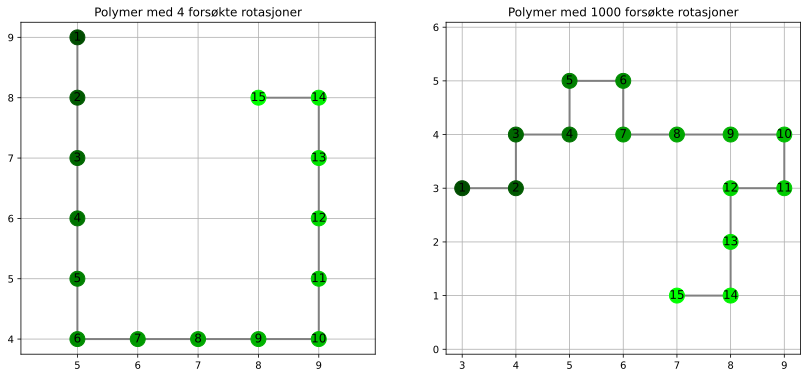

In [44]:
plot_two_polymers(polymer4, polymer1000, 4, 1000, "", "")

### Kodehastighet random rotations
Tester random rotations funksjonene med to forskjellige versjoner av polymer check funksjonen.
Drøfte hvordan kjøretiden (med implementasjonen deres) skalerer med størrelsen på polymeren. 

Når lengden på polymeren øker så vil det også være flere mulige monomerer og rotere rundt.

In [100]:
N_array = np.arange(10, 100, 10)
time_array = np.zeros(len(N_array))
N_s = 100

for i in range(len(N_array)):
    time_array[i] = timeit.timeit(lambda: random_rotations(N_array[i], N_s), number=10)

plt.plot(N_array, time_array)
plt.show()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function len>) found for signature:
 
 >>> len(int64)
 
There are 20 candidate implementations:
   - Of which 20 did not match due to:
   Overload of function 'len': File: <numerous>: Line N/A.
     With argument(s): '(int64)':
    No match.

During: resolving callee type: Function(<built-in function len>)
During: typing of call at /var/folders/5l/6lccgrs11c5gptx481vjpjfh0000gn/T/ipykernel_57235/476954499.py (5)


File "../../../../../../../var/folders/5l/6lccgrs11c5gptx481vjpjfh0000gn/T/ipykernel_57235/476954499.py", line 5:
<source missing, REPL/exec in use?>


In [45]:
def random_rotations_slow(polymer: np.ndarray, N_s: int) -> np.ndarray:

    N = len(polymer)
    counter = 0 
    current_polymer = polymer
    clockwise_draws = np.random.rand(N_s) < 0.5
    mon_idx_draws = np.random.randint(1, N - 1, size=N_s)  # Range [1, N-1), in order to not include end points
    for i in range(N_s):
        clockwise = clockwise_draws[i]
        mon_idx = mon_idx_draws[i]
        twisted_polymer = twist_polymer(polymer=current_polymer, monomer_idx=mon_idx, clockwise=clockwise)
        if polymer_check_slow(twisted_polymer, len(twisted_polymer)):
                        counter +=1
                        current_polymer = twisted_polymer
                        
    return current_polymer, counter

In [ ]:

%timeit random_rotations_slow(init_polymer(15), 1000)
%timeit random_rotations_slow(init_polymer(30), 1000)

%timeit random_rotations(init_polymer(15), 1000)
%timeit random_rotations(init_polymer(30), 1000)


#### Prosentandel gyldige rotasjoner
Vi skal nå se på hvor stor prosentandelen gydlige rotasjoner av polymerer av lengde N er, utifra antall forsøkte simuleringer, N_s. Ved N_s  = 1000 ser vi at antall gyldige rotasjoner starter på rundt 65% ved korte polymerer, mens prosentandelen synker til rundt 50% ved polymerer av lengde N < 30. Når vi minker N_s til 500 er det lite avvik fra grafen for N_s = 1000. Dette er grunnet.... #### Skriv mer ####
Når N_s senkes til 30 forsøkte rotasjoner, ser vi at polymerene av forskjellige lengde N som blir forsøkt rotert N_s = 30, ender opp med et gjennomsnitt på omtrent 65% gyldige rotasjoner, uavhengig av lengden på polymerene.

Polymerene vi har plottet er tilfeldig simulert, derfor vil det være store variasjoner i om polymerene låser seg fast i en posisjon tidlig i simulasjonen. Dersom en polymer låser seg tidlig vil den slutte å rotere og prosentandelen vil falle betraktelig. Dette er grunnen for at det er store variasjoner i grafene, og disse endrer seg for hver gang koden blir kjørt. 


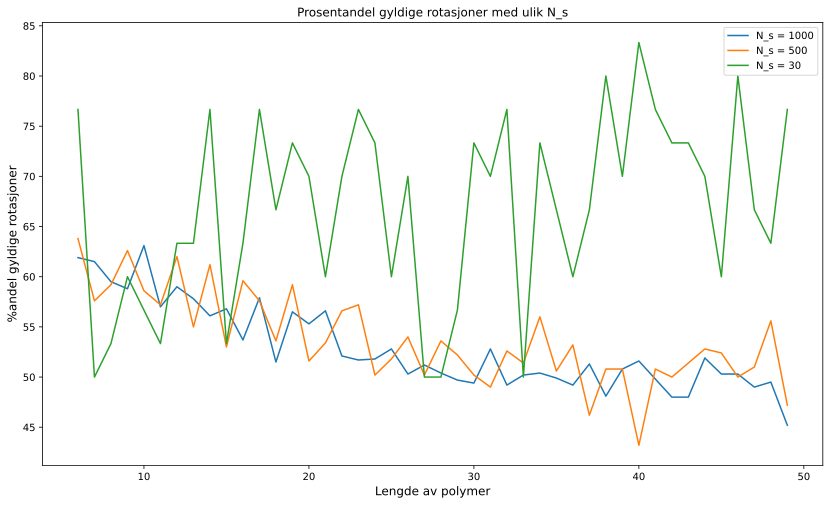

In [46]:
n = 50
N = np.arange(6,n)
y_vals_1000 = np.zeros(len(N))
y_vals_500 = np.zeros(len(N))
y_vals_30 = np.zeros(len(N))

for i in range(len(N)):
    y_vals_1000[i] = ((random_rotations(init_polymer(N[i]), 1000)[1])/1000)*100
    y_vals_500[i] = ((random_rotations(init_polymer(N[i]), 500)[1])/500)*100
    y_vals_30[i] = ((random_rotations(init_polymer(N[i]), 30)[1])/30)*100
   
plt.figure(figsize=(14,8))
plt.plot(N, y_vals_1000, label = "N_s = 1000")
plt.plot(N, y_vals_500, label = "N_s = 500")
plt.plot(N, y_vals_30, label = "N_s = 30")
plt.title("Prosentandel gyldige rotasjoner med ulik N_s")
plt.xlabel("Lengde av polymer", fontsize=12)
plt.ylabel("%andel gyldige rotasjoner", fontsize=12)
plt.legend(fontsize=10)
plt.show()

In [47]:
@njit
def make_V_const(N: int, const_value: float) -> np.ndarray:

    # Create a N x N matrix with constant values
    V = np.full((N, N), const_value)
    
    for i in range(N):
        for j in range(i-1, i+2):
            if 0 <= j < N:
                V[i, j] = 0 
    return V 

In [49]:
# Checks if one monomer is nearest neighbor to another monomer
@njit
def nearest_neighbor(x0: int, y0: int, x1: int, y1: int) -> bool:
    return (np.abs(x0 - x1) + np.abs(y0 - y1)) == 1

@njit
def calculate_energy(twisted_polymer: np.ndarray, V: np.ndarray) -> float: 

    # Assume that V[i, i+1] = V[i+1, i] = V[i, i] = 0 for all i

    energy = 0
    N = twisted_polymer.shape[0]
    for i in range(N):
        for j in range(0, i - 1):
            mon1 = twisted_polymer[i]
            mon2 = twisted_polymer[j]
            if nearest_neighbor(mon1[0], mon1[1], mon2[0], mon2[1]):
                energy += V[i, j] + V[j, i]

    return energy / 2.0

#### Energi
Dersom monomer m ender opp som nærmeste nabo med et monomer som ikke er monomer m - 1 eller m + 1, oppstår det svake vekselsvirkninger mellom monomerene. Dette kan skrives matematisk som:
E = \frac{1}{2} \sum{V \cdot b}
V er en N x N - matrise som inneholder styrken til vekselvirkningene. Vi bruker funksjonen calculate_energy() for å regne ut energien til de to polymerene som er plottet over, en med 4 forsøkte rotasjoner og en med 1000 forsøkte rotasjoner.  

Resultatet vi får er at polymeret som er forsøkt rotert 4 ganger får en energi på -2.0, og energien til polymeret som er forsøkt rotert 1000 ganger får en energi på -5.0. I V-matrisen er alle de ikke 0-elementene konstant lik -1, dette gjør at monomerene får en tiltrekkende kraft mellom hverandre. Polymerene ønsker alltid å oppnå et energiminimum, og ved denne V-matrisen vil energien minimeres ved at polymeren folder seg. Polymeren som er rotert 1000 ganger oppnår lavest energi, noe som stemmer med forventningene våres om at polymerene vil rotere seg et energiminima, der monomerene vil tiltrekke hverandre og det vil oppstå vekselvirkninger mellom monomerene.

In [50]:
print(f"Energien til polymeret som er forsøkt twisted 4 ganger er: {calculate_energy(polymer4, make_V_const(15, -1))}")
print(f"Energien til polymeret som er forsøkt twistet 1000 ganger er: {calculate_energy(polymer1000, make_V_const(15, -1))}")

Energien til polymeret som er forsøkt twisted 4 ganger er: 0.0
Energien til polymeret som er forsøkt twistet 1000 ganger er: -4.0


In [51]:
# Algoritme 2
@njit
def simulate_energy(polymer: np.ndarray, N_s: int, V: np.ndarray, T: int, max_iter=100_000):
    E_array = np.zeros(N_s)
    E = calculate_energy(polymer, V)
    beta = 1 / (1.38*10**(-23)*T)

    i = 0
    while i < N_s:
    # for _ in trange(max_iter, desc="Simulating energy"):
        random_monomer = np.random.randint(1, len(polymer) - 1)  # Randomly choose a monomer
        twist_clockwise = np.random.rand() > 0.5  # Randomly choose the twist direction

        twisted_polymer = twist_polymer(polymer, random_monomer, twist_clockwise)
        if polymer_check(twisted_polymer, len(twisted_polymer)):
            i += 1
            E_new = calculate_energy(twisted_polymer, V)
            if E_new < E or np.random.rand() < np.exp(-beta * (E_new - E)):
                polymer = twisted_polymer
                E = E_new
            E_array[i] = E
        if i >= N_s - 1:
            break

    return polymer, E_array

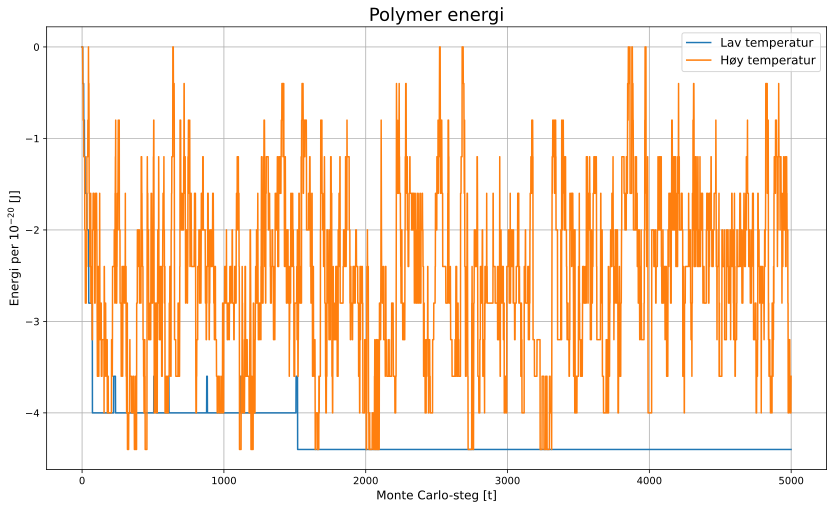

In [52]:
t = 5000
T_low = 70
T_high = 350

V_1 = make_V_const(20, -4.0 * 10**(-21))
V_2 = make_V_const(20, -4.0 * 10**(-21))

_polymer, energy_vals1 = simulate_energy(init_polymer(20), t, V_1, T_low) 
_polymer, energy_vals2 = simulate_energy(init_polymer(20), t, V_2, T_high) 


plt.title("Polymer energi", fontsize=18)
plt.xlabel("Monte Carlo-steg [t]", fontsize=12)
plt.ylabel("Energi per $10^{-20}$ [J]", fontsize=12) 
plt.grid()
plt.plot(np.arange(t), energy_vals1 * 10**20, label = "Lav temperatur")
plt.plot(np.arange(t), energy_vals2 * 10**20, label = "Høy temperatur")
plt.legend(fontsize=12)
plt.gcf().set_size_inches(14, 8)
plt.show()

Grafen viser en tydelig forskjell mellom energien til et polymer med lav temperatur og et polymer med høy temperatur. Som nevnt så vil en vilkårlig polymer prøve å ordne seg slik at den minimerer sin energi. Polymeren med lav temperatur holder et stabilt energinivå. Dette er fordi ved den lave temperaturen finner polymeren lett et lokalt energiminima, og den har vanskelighet for å hoppe ut av denne energitilstanden til en annen. Ved den høye temperaturen ser vi at polymeren er svært ustabil ved at den stadig hopper mellom energinivå. Denne polymeren vil oppnå den laveste energitilstanden, altså det globale minima, men vil lett hoppe ut av denne tilstanden.

Under har vi plottet de to polymerene med lav og høy temperatur vedsiden av hverandre. For hver gang vi kjører koden ser vi at polymeren i høy temperatur vil ha større variasjoner i foldingene, dette er fordi den kan hoppe inn og ut av energiminima. Dette stemmer med det vi ser i grafen over. Den vil kunne strekke seg over ett større området enn polymeren ved lave temperatur. Polymeren ved lav temperatur vil ikke ha like store variasjoner i strukturen for hver gang koden blir kjørt. Dette er fordi under lave temperaturer vil polymeren låse seg fast i ett energiminima. Dette fører til at polymeren ender opp i en mer foldet sluttposisjon den ikke klarer å rotere seg ut av. 

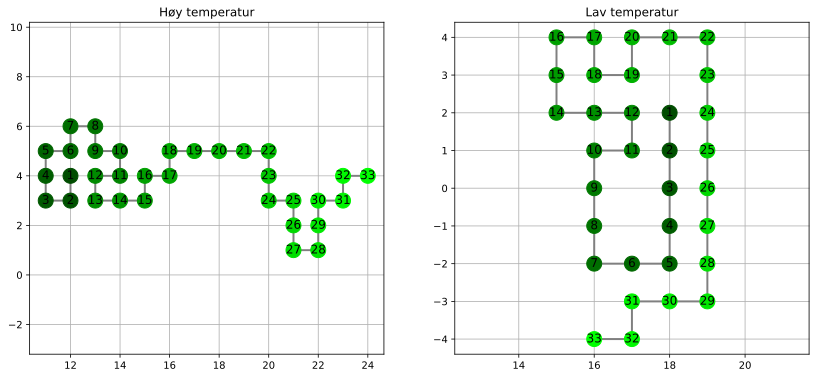

In [53]:
# 2c) Illustrer sluttposisjonen til de to polymerene fra simuleringen i 2b
polymer_high_temp = simulate_energy(init_polymer(33), t, V_1, T_high)[0]
polymer_low_temp = simulate_energy(init_polymer(33), t, V_1, T_low)[0]

plot_two_polymers(polymer_high_temp, polymer_low_temp, t, t, "Høy temperatur", "Lav temperatur")

#### Matrisen V sin påvirkning på sluttresultatet til polymeren
Vi har nå eksperimentert med matrisen V for å prøve å oppnå kule strukturer på polymeren vår. Vi bestemte oss for å prøve å lage en sirkel og et sikksakk mønster. For å kunne gjøre dette er det viktig å forstå ordentlig hvordan matrisen V påvirker de tilfeldige rotasjonene. V består av styrken til velselvirkningene mellom alle monomerene. Dermed vil alltid diagonalen, underdiagonalen og overdiagonalen være 0 siden det ikke er vekselvirkninger mellom monomer m og m-1/m+1. V er også alltid symmetrisk da vekselvirkningene mellom to monomerer skal gå begge veier og være like store. 

I funksjonen make_V_circle() ønsker vi å øke sjansen for å ende med et polymer som har form som en sirkel. Vi ønsker da å få endemonomerene til å tiltrekke hverandre og resten av monomerene til å frastøte hverandre. Først valgte vi kun at endemonomerene skulle ha tiltrekning, men innså da at det ikke var garantert at vi ville ende med en sirkel. For å øke sjansene for at polymeren alltid skal ende som en sirkel, fant vi ut at hvis vi ga de 3 ytterste monomerene tiltrekning så vil vi nærmest alltid ende med en lukket sirkel. Siden monomer m og m-1/m+1 ikke har vekselvirkninger mellom seg så vil det heller ikke bli noe problem at vi gir alle disse tiltrekning. I matrisen V har vi da altså gitt de 9 elementene nederst i venstre hjørne en negativ verdi, tiltrekning, da hver av disse representerer vekselvirkningen mellom monomer 1, 2 og monomer N, N-1 og N-2. Resten av elementene i matrisen har vi gitt en positiv verdi, frastøtning, for så å spile elementene under diagonalen om diagonalen. Siden polymeren ønsker å minimere energien sin ønsker den da at endene skal finne sammen og at restene av monomerene ikke skal være nærmeste nabo med noen andre monomerer. Vi har valgt såpasss stor tiltrekning at når endene først finner sammen så er det veldig liten sannsynlighet for at de går fra hverandre igjen. Dette krever i så fall høy temperatur. Sirkelen vil ikke alltid være like fin, noe som kommmer av at vekselvirkningene kun virker mellom nærmeste naboer, men vi vil med veldig høy sannsynlighet få en lukket polymer med hulrom i midten. 

I funksjonen make_V_folded() ønsker vi å lage et sikksakk mønster. For å få til dette har vi gitt hver tredje monomer tiltrekning og resten 0. Da vil hver tredje monomer finne sammen, noe som vil skape mønster. På samme måte som i sirkelen er det tilfeldige rotasjoner, frem til monomerene finner sammen med andre med tiltrekning. Da vil de med stor sannsynlighet ikke gå fra hverandre igjen da dette krever mye energi og polymeren helst ønsker å minimere energien. Det er heller ikke sikkert at det blir et perfekt sikk sakk mønster, men det med all sannsynlighet mye større sjanse enn ved en V matrise med like elementer. Grunnen til at vi ikke har noen frastøtning i denne matrisen er fordi vi ønsker en kompakt polymer. Vi vil kun påvirke hvilke elementer som skal henge sammen, og ønsker derfor helt vilkårlige rotasjoner fram til de finner sammen, og da ofte blir hengende sammen resten av rotasjonene. Denne funksjonen baserer seg også i all hovedsak på polymerets ønske om å minimere sin egen energi som skjer ved tiltrekningene. 

In [71]:
# V-matrix that generates a circle
@njit
def make_V_circle(N: int, binding_energy=4e-21) -> np.ndarray:
    # Attraction of the three first and three last monomers and repulsion of other monomers
  
    V = np.full((N, N), 5 * binding_energy)

    for i in range(N):
        for j in range(N):
            if np.abs(i - j) <= 1:
                V[i, j] = 0.0
    
    V[N-3:N, :3] = V[:3, N-3:N] = -100 * binding_energy
    
    return V 

# V-matrix that generates a zig-zag pattern
@njit
def make_V_folded(N: int, binding_energy=4e-21) -> np.ndarray:
    # Every third monomer is attracted to the monomer 6 indices ahead

    V = np.full((N, N), binding_energy)
    binding_energy *= 10

    for i in range(N):
        if i % 6 == 0 and i + 5 < N:
            V[i, i + 5] = V[i + 5, i] = -binding_energy
        elif i % 6 == 1 and i + 3 < N:
            V[i, i + 3] = V[i + 3, i] = -binding_energy
        elif i % 6 == 3 and i + 5 < N:
            V[i, i + 5] = V[i + 5, i] = -binding_energy
        elif i % 6 == 4 and i + 3 < N:
            V[i, i + 3] = V[i + 3, i] = -binding_energy

    return V

# High value top right, and lowest on bottom left 
print(make_V_folded(8))# høy verdi øverst høyre og lavest nederst venstre
print(make_V_circle(8))

[[ 4.e-21  4.e-21  4.e-21  4.e-21  4.e-21 -4.e-20  4.e-21  4.e-21]
 [ 4.e-21  4.e-21  4.e-21  4.e-21 -4.e-20  4.e-21  4.e-21  4.e-21]
 [ 4.e-21  4.e-21  4.e-21  4.e-21  4.e-21  4.e-21  4.e-21  4.e-21]
 [ 4.e-21  4.e-21  4.e-21  4.e-21  4.e-21  4.e-21  4.e-21  4.e-21]
 [ 4.e-21 -4.e-20  4.e-21  4.e-21  4.e-21  4.e-21  4.e-21 -4.e-20]
 [-4.e-20  4.e-21  4.e-21  4.e-21  4.e-21  4.e-21  4.e-21  4.e-21]
 [ 4.e-21  4.e-21  4.e-21  4.e-21  4.e-21  4.e-21  4.e-21  4.e-21]
 [ 4.e-21  4.e-21  4.e-21  4.e-21 -4.e-20  4.e-21  4.e-21  4.e-21]]
[[ 0.e+00  0.e+00  2.e-20  2.e-20  2.e-20 -4.e-19 -4.e-19 -4.e-19]
 [ 0.e+00  0.e+00  0.e+00  2.e-20  2.e-20 -4.e-19 -4.e-19 -4.e-19]
 [ 2.e-20  0.e+00  0.e+00  0.e+00  2.e-20 -4.e-19 -4.e-19 -4.e-19]
 [ 2.e-20  2.e-20  0.e+00  0.e+00  0.e+00  2.e-20  2.e-20  2.e-20]
 [ 2.e-20  2.e-20  2.e-20  0.e+00  0.e+00  0.e+00  2.e-20  2.e-20]
 [-4.e-19 -4.e-19 -4.e-19  2.e-20  0.e+00  0.e+00  0.e+00  2.e-20]
 [-4.e-19 -4.e-19 -4.e-19  2.e-20  2.e-20  0.e+00  0.e+00  0.

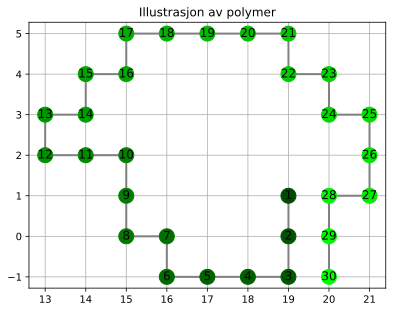

In [69]:
# Setting the polymer length
N = 30

# Plot of circle shaped polymer:
polymerS = simulate_energy(polymer=init_polymer(N), N_s=100_000, V=make_V_circle(N), T=350)[0]
plot_polymer(polymerS)

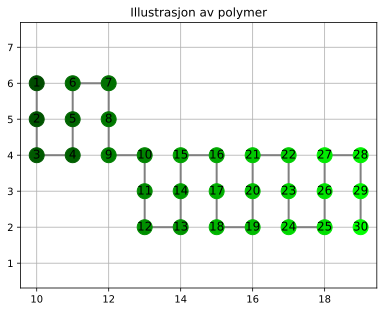

In [70]:
# Plot of zig-zag shaped polymer:
polymerZ = simulate_energy(polymer=init_polymer(N), N_s=100_000, V=make_V_folded(N), T=350)[0]
plot_polymer(polymerZ)

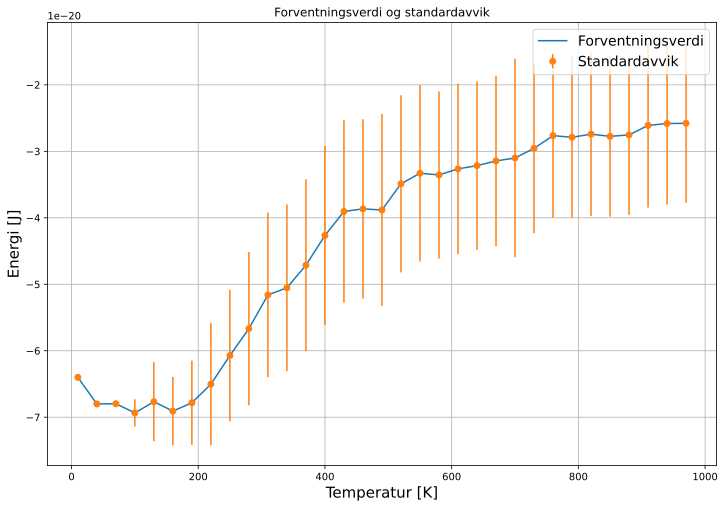

In [92]:
#2e)

N_p = 30
N_s = 10_000
V = make_V_const(N_p, -4e-21)
T = np.arange(start=10, stop=1000, step=30)

E_array_mean = np.zeros(len(T))
E_array_sd = np.zeros(len(T))

polymer0 = init_polymer(N_p)

for i in range(len(T)):
    _polymer, E_array = simulate_energy(polymer0, N_s, V, T[i], max_iter=100_000)

    # Excluding the first 1000 simulation steps
    E_array_mean[i] = np.mean(E_array[1000:])
    E_array_sd[i] = np.std(E_array[1000:])

plt.figure(figsize=(12,8))
plt.plot(T, E_array_mean, label="Forventningsverdi")
plt.errorbar(T, E_array_mean, yerr=E_array_sd, fmt='o', label="Standardavvik")
plt.legend(fontsize=14)
plt.title("Forventningsverdi og standardavvik")
plt.xlabel("Temperatur [K]", fontsize=15)
plt.ylabel("Energi [J]", fontsize=15)
plt.grid()
plt.show()

Grafen forteller oss at ved lav temperatur er forventa energi lav. Vi observerer også at standardavvikket ved de laveste temperaturene er veldig lite. Dette skyldes fenomenet vi så i forrige energigraf, der polymeret hadde lett for å låse seg fast i et lokalt energiminima ved lav temperatur. Ved låsing av polymeret vil energien klart holde seg konstant, og derav får vi et svært lite standardaavik for forventet energi. Vi ser at når temperaturen overstiger rundt 200 Kelvin og går mot varmere temperaturer, stiger forventet energi mye og standardavvikene blir store. Dette stemmer overens med observasjonen vår om at en polymer ved høy temperatur er energimessig kaotisk og hopper stadig mellom energinivå. Ved høy temperatur er det altså uforventa hvilken energi polymeren får og denne uforutsigbarheten gir oss det høye standardavviket.

Hvordan påvirker valget deres av Ns temper- aturavhengigheten til ⟨E⟩?

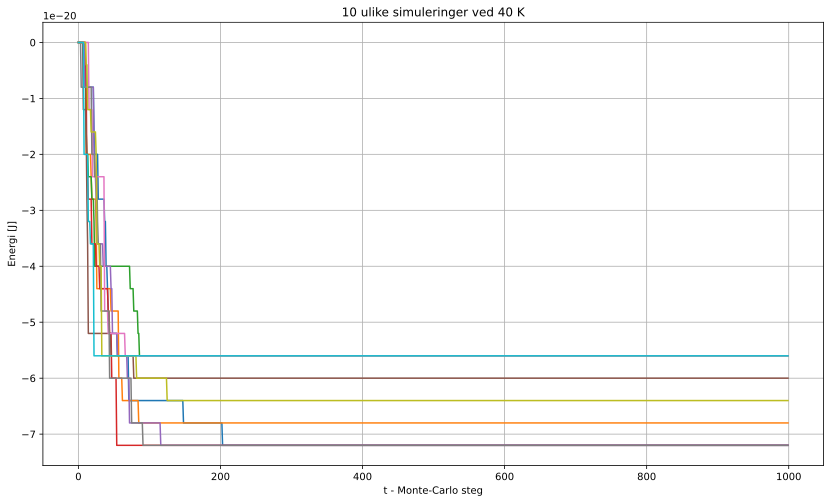

In [58]:
#2f)

T = 40
t = 1000
x_vals = np.arange(t)
plt.figure(figsize=(14, 8))

for _ in range(10):
    E_array = simulate_energy(init_polymer(N), t, V, T, max_iter=100_000)[1]
    plt.plot(x_vals, E_array)

plt.title(f"10 ulike simuleringer ved {T} K")
plt.xlabel("t - Monte-Carlo steg")
plt.ylabel("Energi [J]")
plt.grid()
plt.show()

De 10 simuleringene ved samme lave temperatur bekrefter det vi har sett tidligere. Alle polymerene finner tidlig et lokalt energiminima og klarer ikke hoppe ut av det, derav stabiliserer grafene seg. Ved å kjøre de 10 simuleringeringene og plotte de i samme graf kan man enklere anslå energien til en kald polymer ved å se på hvilket temperaturintervall grafene er stabile ved.

In [59]:
@njit
def make_V_random(N: int) -> np.ndarray:

    V = np.full((N, N), 0.0)

    for i in range(N):
        for j in range(0, i - 1):
                V[i, j] = V[j, i] = np.random.uniform(-6e-21, -2e-21)

    return V

print(make_V_random(5))

[[ 0.00000000e+00  0.00000000e+00 -4.07362847e-21 -3.27121118e-21
  -5.73618299e-21]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.54794822e-21
  -4.31970704e-21]
 [-4.07362847e-21  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.31263074e-21]
 [-3.27121118e-21 -3.54794822e-21  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.73618299e-21 -4.31970704e-21 -5.31263074e-21  0.00000000e+00
   0.00000000e+00]]


For å finne den største Euklidiske avstanden mellom to monomerer i polymeren brukte vi en dobbeltløkke der vi regner ut avstanden fra en monomer til alle de etterfølgende monomerene ved hjelp av pythagoras. Legg merke til at ved denne metoden sjekker vi ikke samme avstand to ganger, noe som er bra for kjøretiden. Å ta kvadratrot er en kjøretidsmessig kostbar operasjon, så vi velger derfor å først finne maksimum distanse og ta kvadratroten helt til slutt.

In [60]:
@njit
def max_euclidean_distance(polymer: np.ndarray) -> float:
    N = len(polymer)

    # Find maximum distance^2 between two monomers
    max_dist2 = 0.0
    for i in range(N):
        for j in range(i+1, N):
            max_dist2 = max(max_dist2, (polymer[i][0] - polymer[j][0]) ** 2 + (polymer[i][1] - polymer[j][1]) ** 2)

    # Take the square root of maximum distance^2
    return np.sqrt(max_dist2)


In [61]:
# Algoritme 2 med diameter
@njit
def simulate_energy_with_diameter(polymer, N_s, V, T: np.ndarray, max_iter=100_000):
    E_array = np.zeros(N_s)
    d_array = np.zeros(N_s)
    E = calculate_energy(polymer, V)
    beta = 1 / (1.38*10**(-23)*T) # Example calculation, adjust as needed

    i = 0 
    while i < N_s:
    # for _ in trange(max_iter, desc="Simulating energy"):
        random_monomer = np.random.randint(0, len(polymer))  # Randomly choose a monomer
        twist_clockwise = np.random.rand() < 0.5  # Randomly choose the twist direction

        twisted_polymer = twist_polymer(polymer, random_monomer, twist_clockwise)
        if polymer_check(twisted_polymer, len(twisted_polymer)):
            E_new = calculate_energy(twisted_polymer, V)
            if E_new < E or np.random.rand() < np.exp(-beta * (E_new - E)):
                polymer = twisted_polymer
                E = E_new
            E_array[i] = E
            d_array[i] = max_euclidean_distance(polymer)
            i += 1
        if i >= N_s - 1:
            break

    return polymer, E_array, d_array

print(simulate_energy_with_diameter(init_polymer(15), 100, make_V_random(15),300)[2])

[10.29563014 10.         10.         10.         10.         10.
  8.54400375  8.54400375  8.54400375  8.54400375  7.21110255  7.21110255
  5.65685425  5.65685425  7.21110255  8.06225775  5.83095189  6.70820393
  6.70820393  6.70820393  6.40312424  6.40312424  6.40312424  6.40312424
  6.40312424  6.40312424  5.83095189  5.83095189  5.83095189  5.83095189
  5.83095189  6.40312424  6.40312424  6.40312424  6.40312424  5.
  6.70820393  5.83095189  6.70820393  6.08276253  6.08276253  6.08276253
  6.40312424  6.40312424  8.06225775  8.06225775  8.06225775  8.54400375
  9.43398113  5.38516481  5.38516481  6.40312424  6.32455532  6.32455532
  5.38516481  5.38516481  5.38516481  5.38516481  5.38516481  5.38516481
  5.38516481  5.38516481  5.38516481  5.38516481  7.07106781  6.40312424
  5.83095189  5.83095189  5.83095189  5.83095189  5.83095189  5.83095189
  5.83095189  5.83095189  6.40312424  5.09901951  5.09901951  5.
  5.65685425  5.65685425  5.65685425  5.65685425  5.          5.65685425
  

In [62]:
N = 30
N_s = 10_000

V = make_V_random(N)
T = np.arange(10, 1000, 30)
d_array_mean_heating = np.zeros(len(T))

initial_polymer = init_polymer(N)

for i in range(len(T)):
    _polymer, _E_array, d_array = simulate_energy_with_diameter(init_polymer(N), N_s, V, T[i], max_iter=100_000)
    d_array_mean_heating[i] = np.mean(d_array[1000:])


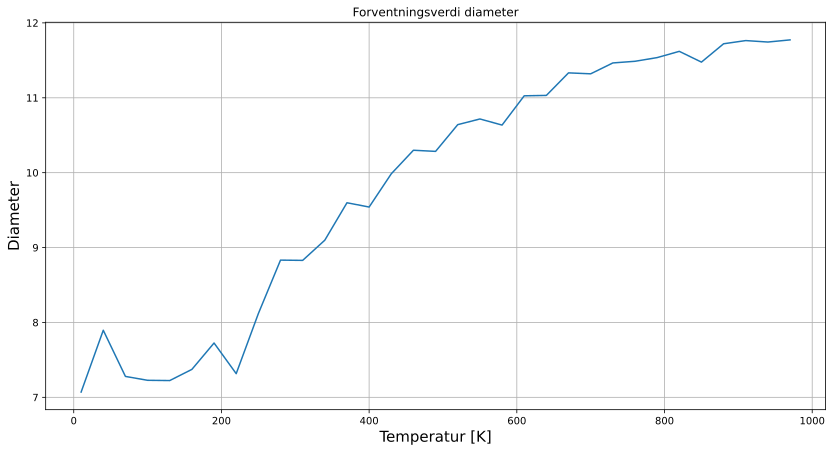

In [63]:
plt.figure(figsize=(14,7))
plt.plot(T, d_array_mean_heating, label="Forventningsverdi")
plt.title("Forventningsverdi diameter")
plt.xlabel("Temperatur [K]", fontsize=15)
plt.ylabel("Diameter", fontsize=15)
plt.grid()
plt.show()

(Oppgi hvor lang kjøretid alle simuleringene til sammen tok)
Ut ifra grafen kan vi se at den forventede største Euklidiske avstanden <d> øker i samsvar med temperaturen. Det vil si den største avstanden mellom to monomerer øker med energien til polymeren.

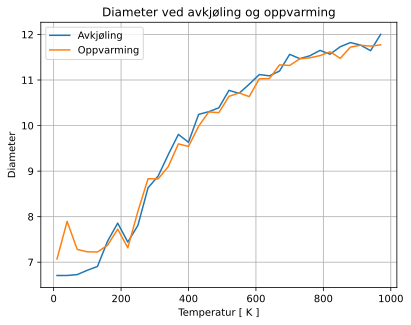

In [72]:
T_rev = T[::-1]

d_array_mean_cooling = np.zeros(len(T_rev))
running_polymer = init_polymer(N)
for i in range(len(T_rev)):
    # Reuse polymer
    running_polymer, _E_array, d_array = simulate_energy_with_diameter(running_polymer, N_s, V, T_rev[i], max_iter=100_000)
    d_array_mean_cooling[i] = np.mean(d_array[1000:])

plt.title("Diameter ved avkjøling og oppvarming")
plt.xlabel("Temperatur [ K ]")
plt.ylabel("Diameter")
plt.plot(T, d_array_mean_cooling[::-1], label = "Avkjøling")
plt.plot(T, d_array_mean_heating, label = "Oppvarming")
plt.legend(fontsize=10)
plt.grid()
plt.show()

# Ved avkjøling vil den fryses 
# Ved oppvarming starter man ikke ved et energiminima

Hva slags (enkel) fysisk prosess tilsvarer dette?
Sammenlign m ̊aleseriene i lys av de to forskjellige metodene som ble brukt i simuleringene. Drøft hvilken av metodene som egner seg best for å se på både lav- og høytemperaturoppførselen til en polymer.

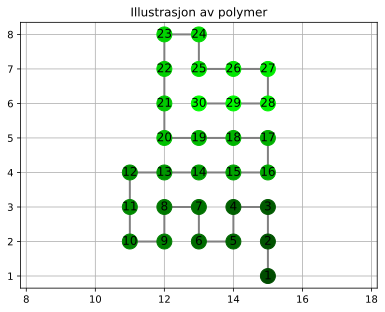

In [65]:
plot_polymer(running_polymer)